In [5]:
import numpy as np
import struct
from array import array
import tensorflow as tf
from tensorflow.keras import layers, models # type: ignore
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau # type: ignore
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns


#### MNIST Data loader

In [3]:

class MnistDataloader(object):
    def __init__(self, training_images_filepath, training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        # Convert labels to numpy array
        labels = np.array(labels)
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train), (x_test, y_test)


# Set file paths based on your MNIST Datasets
training_images_filepath = 'mnist_dataset/train-images.idx3-ubyte'
training_labels_filepath = 'mnist_dataset/train-labels.idx1-ubyte'
test_images_filepath = 'mnist_dataset/t10k-images.idx3-ubyte'
test_labels_filepath = 'mnist_dataset/t10k-labels.idx1-ubyte'


# Load MINST dataset
print('Loading MNIST dataset...')
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()
print('MNIST dataset loaded.')


Loading MNIST dataset...
MNIST dataset loaded.


#### Preparing the dataset

In [4]:

# Convert data to numpy arrays and normalize
x_train = np.array(x_train, dtype=np.float32) / 255.0
x_test = np.array(x_test, dtype=np.float32) / 255.0

# Add a channel dimension to the data (grayscale images, so the channel size is 1)
x_train = x_train[..., np.newaxis]
x_test = x_test[..., np.newaxis]


#### Building Model

In [7]:

# Define the CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')  # 10 output neurons for 10 classes
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 3, 3, 64)          36928     
                                                                 
 flatten_1 (Flatten)         (None, 576)              

In [8]:
# Define EarlyStopping callback to stop training when validation accuracy stops improving
early_stopping = EarlyStopping(
    monitor='val_loss',    # Monitor validation loss
    patience=3,            # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restore best weights when training stops
)

# Define ModelCheckpoint callback to save the best model based on validation accuracy
model_checkpoint = ModelCheckpoint(
    'best_model.h5',       # Path to save the model
    monitor='val_accuracy',
    save_best_only=True,   # Only save the best model
    save_weights_only=False,  # Save the entire model
    mode='max',            # Monitor for maximum validation accuracy
    verbose=1
)

# Define ReduceLROnPlateau callback to reduce learning rate when validation accuracy plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',    # Monitor validation loss
    factor=0.5,            # Reduce learning rate by 50%
    patience=2,            # Number of epochs with no improvement before reducing LR
    verbose=1
)

# Train the model
history = model.fit(
    x_train, y_train,  # Train data
    epochs=20,         # Increase epochs to allow better learning
    batch_size=64,     # Batch size
    validation_data=(x_test, y_test),  # Validation data
    callbacks=[early_stopping, model_checkpoint, reduce_lr]  # Callbacks
)

Epoch 1/20
938/938 [==============================] - ETA: 0s - loss: 0.1867 - accuracy: 0.9419
Epoch 1: val_accuracy improved from -inf to 0.98500, saving model to best_model.h5
938/938 [==============================] - 10s 5ms/step - loss: 0.1867 - accuracy: 0.9419 - val_loss: 0.0473 - val_accuracy: 0.9850 - lr: 0.0010
Epoch 2/20
935/938 [============================>.] - ETA: 0s - loss: 0.0494 - accuracy: 0.9845
Epoch 2: val_accuracy did not improve from 0.98500
938/938 [==============================] - 4s 4ms/step - loss: 0.0495 - accuracy: 0.9844 - val_loss: 0.0484 - val_accuracy: 0.9835 - lr: 0.0010
Epoch 3/20
933/938 [============================>.] - ETA: 0s - loss: 0.0349 - accuracy: 0.9889
Epoch 3: val_accuracy improved from 0.98500 to 0.98980, saving model to best_model.h5
938/938 [==============================] - 4s 4ms/step - loss: 0.0349 - accuracy: 0.9889 - val_loss: 0.0367 - val_accuracy: 0.9898 - lr: 0.0010
Epoch 4/20
936/938 [============================>.] - ETA: 

In [14]:
model.load_weights('best_model.h5')

#### Evaluation

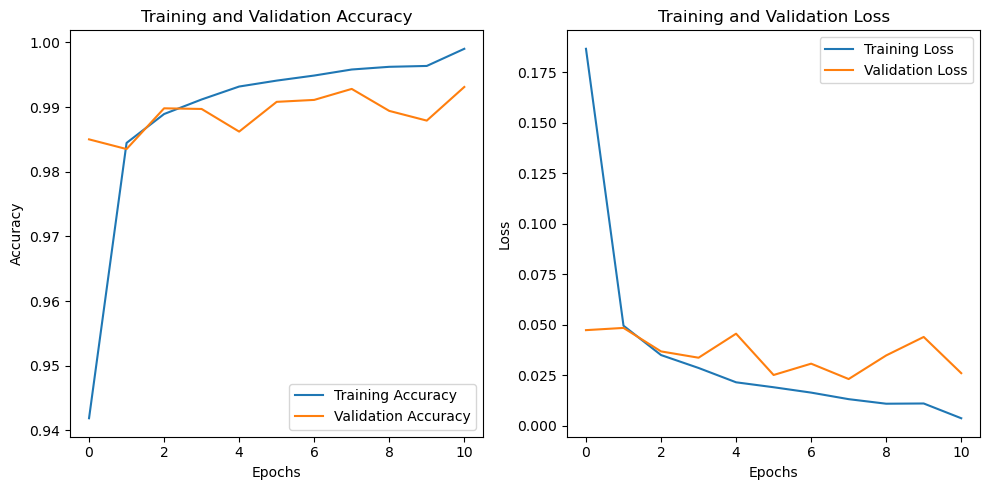

In [15]:

# Plot the training and validation accuracy
plt.figure(figsize=(10, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

In [16]:
# Evaluate the model on test data
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f'Test accuracy: {test_acc}')


313/313 - 1s - loss: 0.0230 - accuracy: 0.9928 - 943ms/epoch - 3ms/step
Test accuracy: 0.9927999973297119


313/313 [==============================] - 1s 2ms/step


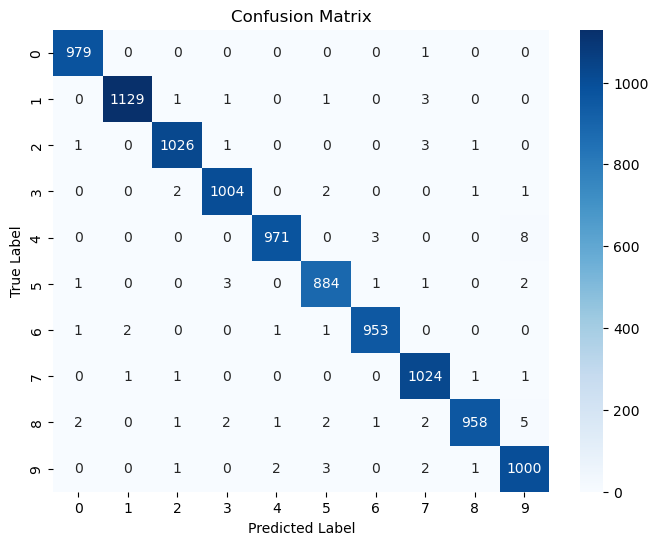

In [17]:

# Get predictions for a subset of test data
predictions = model.predict(x_test)
predictions = np.argmax(predictions, axis=1)


# Confusion Matrix for the subset
conf_matrix = confusion_matrix(y_test, predictions)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

1/1 [==============================] - 0s 13ms/step


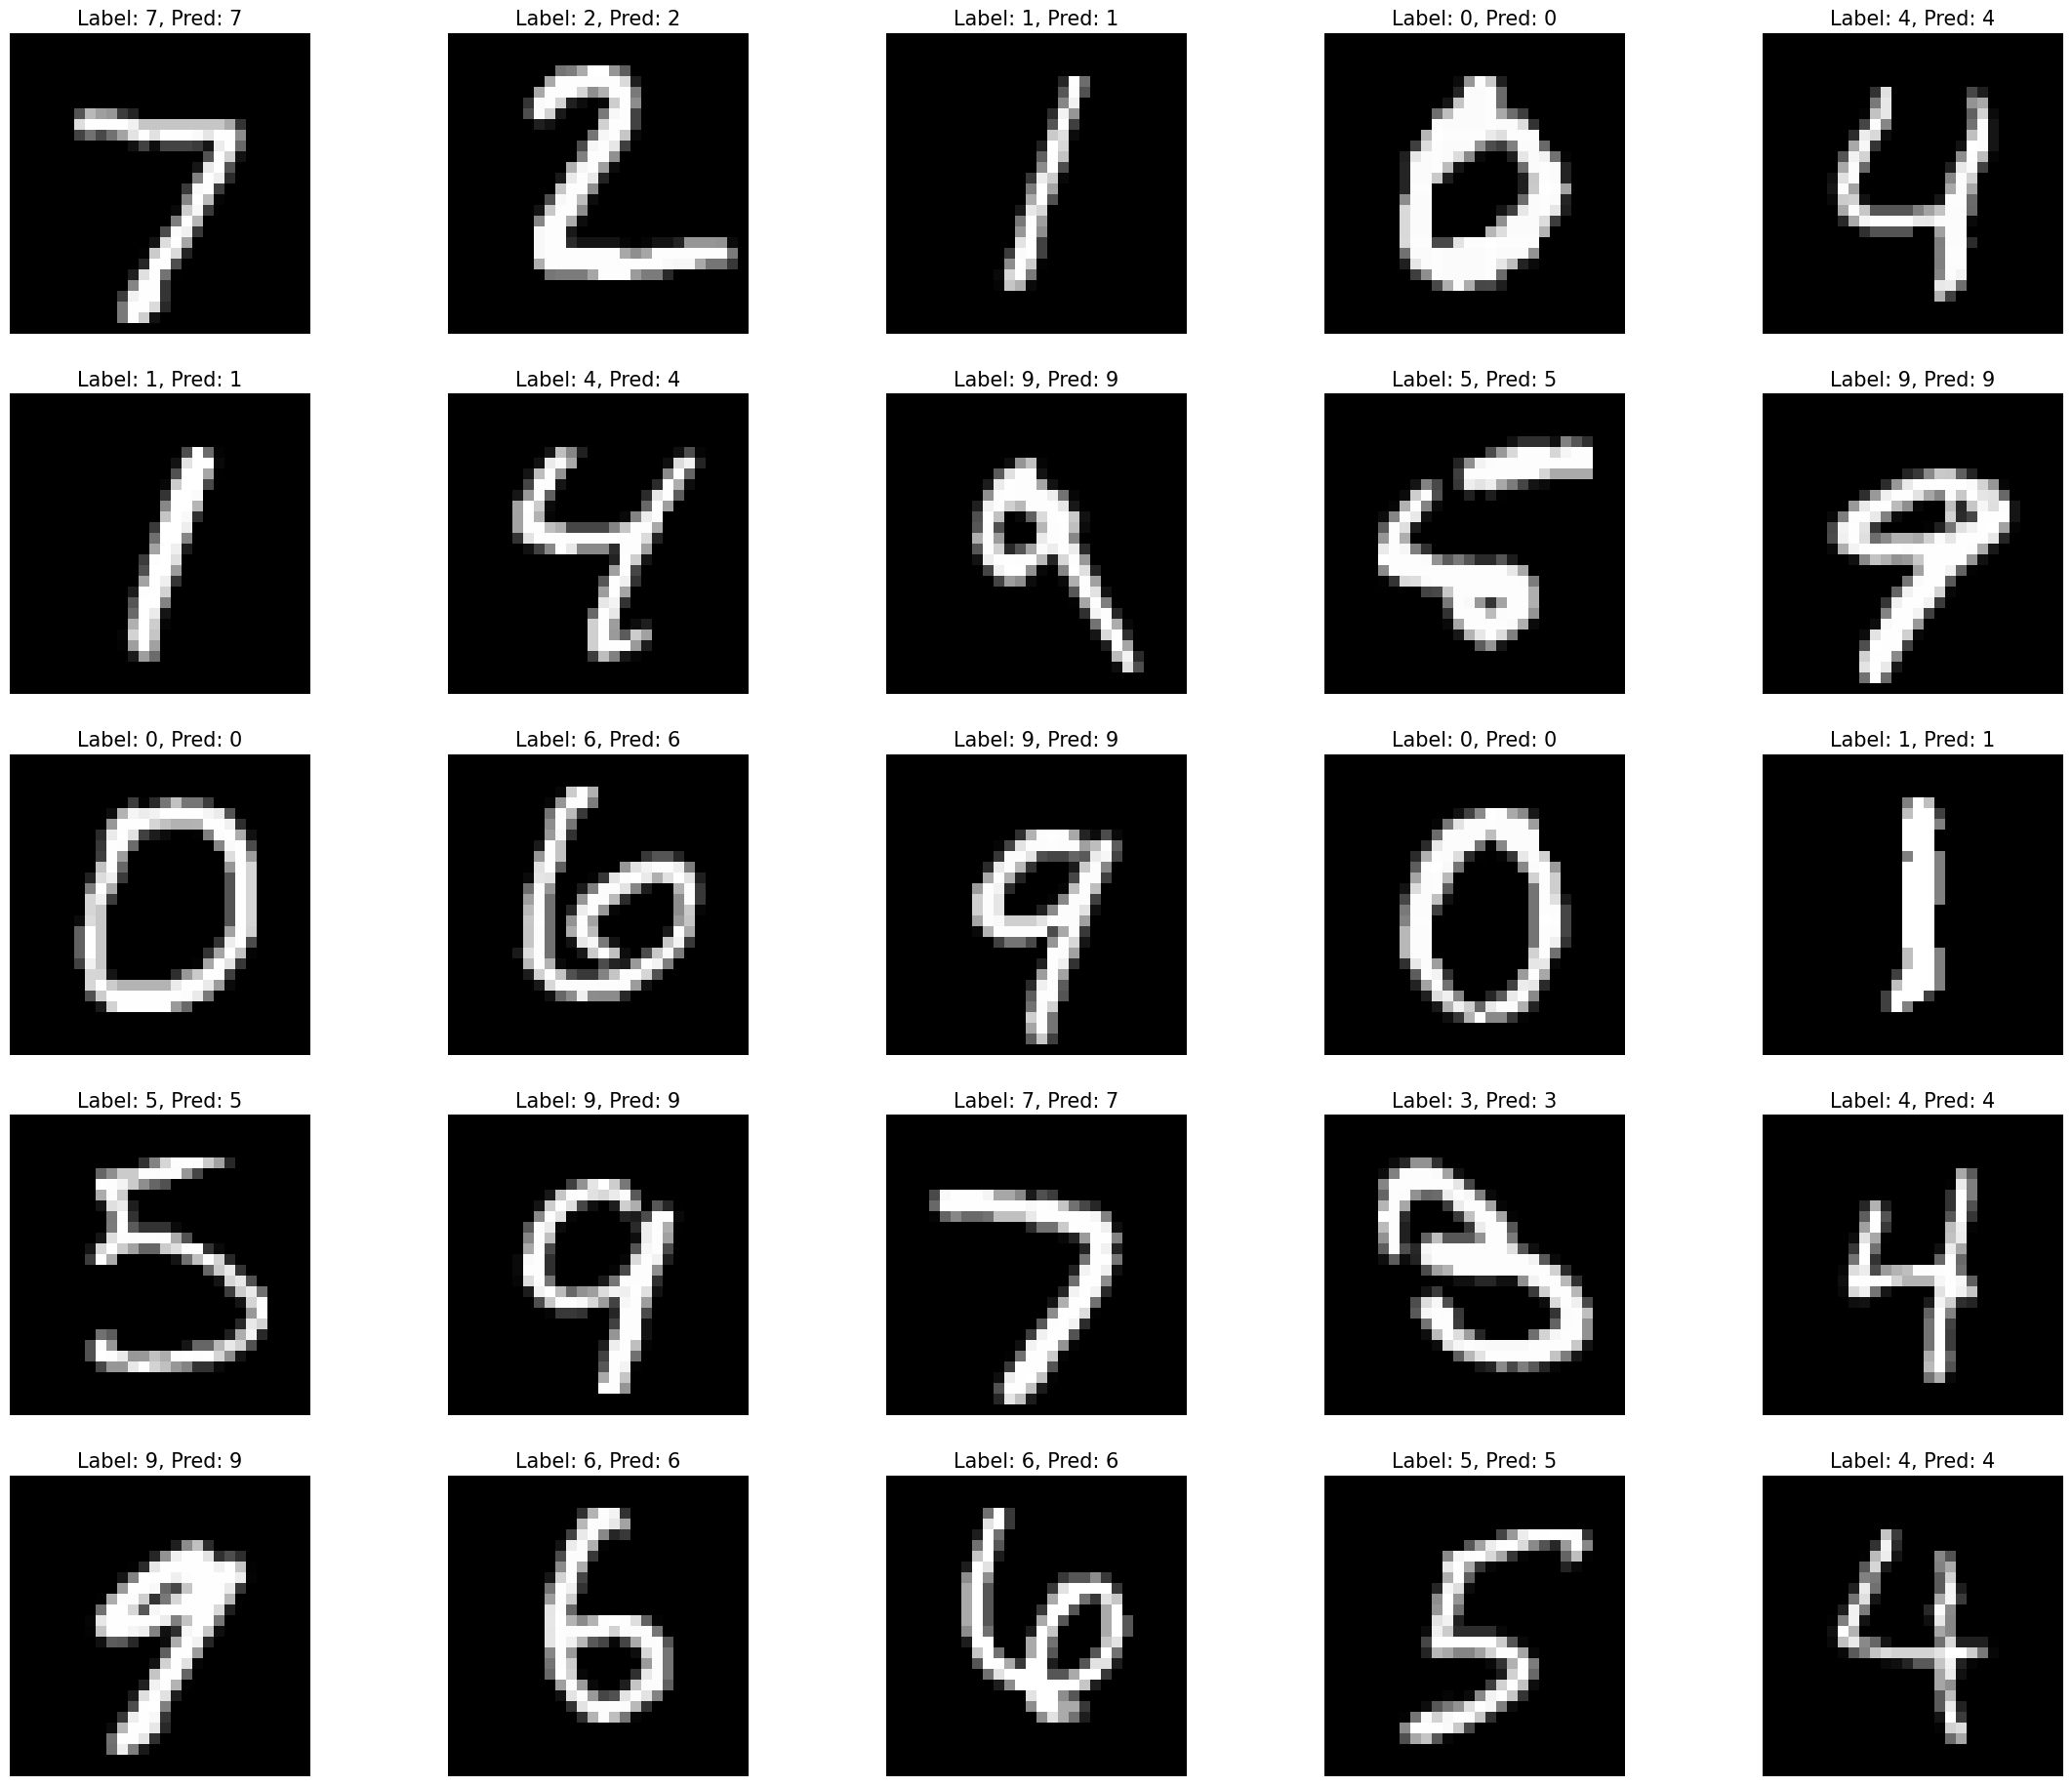

In [18]:

# Show some test images and predictions
def show_images(images, labels, predictions=None):
    cols = 5
    rows = int(len(images) / cols) + 1
    plt.figure(figsize=(28, 28))
    index = 1
    for i in range(len(images)):
        plt.subplot(rows, cols, index)
        plt.imshow(images[i], cmap=plt.cm.gray)
        title_text = f'Label: {labels[i]}'
        if predictions is not None:
            title_text += f', Pred: {predictions[i]}'
        plt.title(title_text, fontsize=15)
        plt.axis('off')
        index += 1

# Get predictions for test data
predictions = model.predict(x_test[:25])
predictions = np.argmax(predictions, axis=1)

# Show random test images with predicted labels
show_images(x_test[:25], y_test[:25], predictions)


In [13]:
# Save the model in the SavedModel format
model.save('best.h5')